In [1]:
ls

Aggregation.txt                noisy_circles79frames.gif
Aggregation.txt12frames.gif    noisy_moons100frames.gif
Aggregation.txt20frames.gif    no_structure100frames.gif
Aggregation.txt22frames.gif    pathbased.txt100frames.gif
Aggregation.txt3frames.gif     pogo.ipynb
animation-400.mp4              R15.txt
animation-b.mp4                R15.txt100frames.gif
animation-c.mp4                R15.txt17frames.gif
animation-d.mp4                R15.txt22frames.gif
animation.gif                  R15.txt36frames.gif
animation.mp4                  R15.txt93frames.gif
aniso100frames.gif             README.md
aniso60frames.gif              spiral20frames.mp4
Compound.txt                   spiral40frames.mp4
Compound.txt22frames.gif       spiral.txt
D31.txt                        spiral.txt19frames.gif
D31.txt22frames.gif            spiral.txt20frames.gif
dbscan-demo-data100frames.gif  spiral.txt29frames.gif
dbscan-demo-data79frames.gif   spiral.txt49frames.gif
dbscan-demo-data99frames.gif   spira

In [2]:
import numpy as np
import pandas as pd
import gudhi

In [3]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.collections import PatchCollection

In [4]:

from sklearn import datasets

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

import os.path

In [5]:
from urllib.request import urlopen
from urllib.parse import urlparse

In [6]:
%matplotlib inline

In [7]:
cmap = plt.cm.get_cmap("flag").copy()
cmap.set_bad(cmap(0))
cmap.set_under(cmap(1))
cmap.get_bad()
#cmap(number_of_clusters)

array([1., 0., 0., 1.])

#randomized blobs with standard deviation
n = 6
std = np.random.random_sample((n,))
#std = 1
X, y, z = make_blobs(
    n_samples=n*100,
    n_features=2,
    centers=n,
    cluster_std=std,
    center_box=(-10.0, 10.0),
    shuffle=False,
    random_state=42,
    return_centers=True,
)



size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [8]:
#data from scikitlearn tutorial on clustering 

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), np.ones(n_samples,dtype='int')

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

In [9]:
X=noisy_moons[0]
y=noisy_moons[1]
filename = 'noisy_moons'


In [10]:
#DBSCAN Demo Data from scikitlearn
centers = [[1, 1], [-1, -1], [1, -1]]
X, y = datasets.make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)
filename = 'dbscan-demo-data'

In [11]:

urls_with_ground_truth = ['https://cs.joensuu.fi/sipu/datasets/D31.txt',
        'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
        'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
        'https://cs.joensuu.fi/sipu/datasets/R15.txt']

urls_without_ground_truth = ['https://cs.joensuu.fi/sipu/datasets/D31.txt',
        'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
        'https://cs.joensuu.fi/sipu/datasets/overlap.txt',
        'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
        'https://cs.joensuu.fi/sipu/datasets/a1.txt',
        'https://cs.joensuu.fi/sipu/datasets/R15.txt']

ground_truth_urls = ['https://cs.joensuu.fi/sipu/datasets/overlap.pa'
    
]

urls_with_ground_truth = {
    urlparse(url).path.strip('/').split('/')[-1] : url for url in urls_with_ground_truth
}


urls_without_ground_truth = {
    urlparse(url).path.strip('/').split('/')[-1] : url for url in urls_without_ground_truth
}


ground_truth = {
    urlparse(url).path.strip('/').split('/')[-1] : url for url in ground_truth_urls
}

In [12]:
urls_with_ground_truth

{'D31.txt': 'https://cs.joensuu.fi/sipu/datasets/D31.txt',
 'spiral.txt': 'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
 'pathbased.txt': 'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
 'R15.txt': 'https://cs.joensuu.fi/sipu/datasets/R15.txt'}

In [13]:
ground_truth

{'overlap.pa': 'https://cs.joensuu.fi/sipu/datasets/overlap.pa'}

In [14]:
def return_dataset(filename):
    if filename in urls_with_ground_truth:
        url= urls_with_ground_truth[filename]
        print(url)
        parse = urlparse(url)
        print(filename)
        raw_data = urlopen(url)
        data = np.loadtxt(raw_data)

        print(data.shape)
        print(data[:10])

        y = data[:,2]
        print(y.shape)
        X = data[:,:2]
        print(X.shape)
        return X, y, filename
    else:
        pass

In [15]:
#X, y, filename = return_dataset('R15.txt')

In [16]:
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target

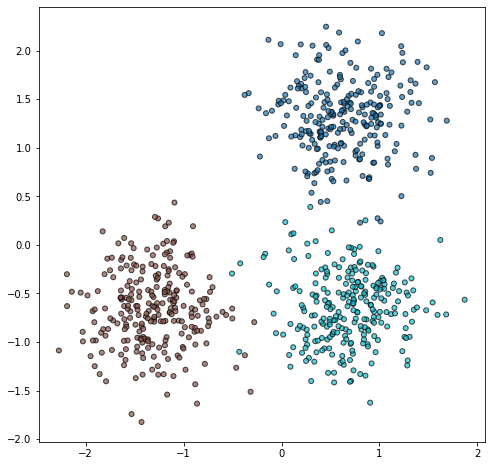

In [17]:
size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [18]:
rips_complex = gudhi.RipsComplex(points=X)

In [19]:
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
   
print(simplex_tree.num_vertices() , 'vertices')  
print(simplex_tree.num_simplices(), 'simplices')
print('dimension:', simplex_tree.dimension())

750 vertices
281625 simplices
dimension: 1


usetex mode requires TeX.


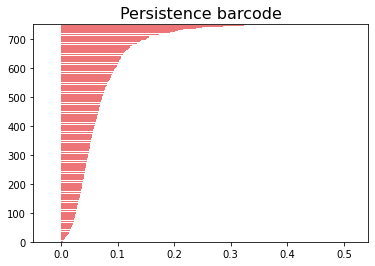

In [20]:
diag = simplex_tree.persistence()
gudhi.plot_persistence_barcode(diag)
plt.show()

In [21]:
#move through list and assign clusters to conected components
point_dict={i:0 for i in range(simplex_tree.num_vertices())}
counter=0
cluster_dict_list = []
distance_list = []
for simplex in simplex_tree.get_filtration():
    if len(simplex[0])>1:
        if all(value > 0 for value in list(point_dict.values())):
            if len(np.unique(np.array(list(point_dict.values())))) == 1:
                print('break')
                print(simplex)
                print(simplex[1])
                simplex_tree.prune_above_filtration(simplex[1])
                break


        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] == 0:
            counter += 1
            point_dict[simplex[0][0]] = counter
            point_dict[simplex[0][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] != 0:
            point_dict[simplex[0][0]] = point_dict[simplex[0][1]]

            #and vice versa
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] == 0:
            point_dict[simplex[0][1]] = point_dict[simplex[0][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] != 0 and point_dict[simplex[0][0]] != point_dict[simplex[0][1]]:
            larger_cluster_number = max(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            smaller_cluster_number = min(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
                    
        distance_list.append(simplex[1])
        cluster_dict_list.append(point_dict.copy())

break
([341, 734], 0.4931677093413331)
0.4931677093413331


In [22]:
max(distance_list)

0.49315949883727617

In [23]:
len(distance_list)

32363

In [24]:
distance_array = np.array(distance_list)
print(len(distance_array))
distance_array.dtype

32363


dtype('float64')

In [25]:
length = len(cluster_dict_list)
length

32363

In [26]:
print(simplex_tree.num_simplices(), 'simplices')
#?

33114 simplices


In [27]:
#check that all clusters have merged
len(np.unique(np.array(list(point_dict.values()))))

1

In [28]:
print(cluster_dict_list[-2].values()) #penultimate clustering has 2 clusters
print(cluster_dict_list[-1].values()) #last clustering finally merges to all one cluster

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [29]:
#find the gaps between birth/death pairs
gaps = np.diff(distance_array)
gaps.shape

(32362,)

In [30]:
#add a zero back to the beginning of the gaps
gaps = np.concatenate([np.zeros(1),gaps])

In [31]:
#find normalized distance
scaler = MinMaxScaler()
normed_distance = scaler.fit_transform(distance_array.reshape(-1,1)).T.reshape(length)

In [32]:
#then invert them and multiply by the gaps to weight early connections in the filtration
inverted_normed_distance = 1 - normed_distance
inverted_normed_distance

array([1.00000000e+00, 9.98063768e-01, 9.96270714e-01, ...,
       4.00172919e-05, 6.88274776e-06, 1.11022302e-16])

In [33]:
#and square it to increase the weighting
#inverted_normed_distance = np.power(inverted_normed_distance,2)

In [34]:
inverted_normed_distance

array([1.00000000e+00, 9.98063768e-01, 9.96270714e-01, ...,
       4.00172919e-05, 6.88274776e-06, 1.11022302e-16])

In [35]:
normed_gaps = np.multiply(gaps, inverted_normed_distance)
normed_gaps

array([0.00000000e+00, 9.49556887e-04, 8.77760567e-04, ...,
       4.49948764e-10, 1.12059379e-10, 3.75471900e-22])

In [36]:
#normalize to create a probability vector
gap_vector = normed_gaps / np.sum(normed_gaps)

In [37]:
#check
np.sum(gap_vector)

0.9999999999999999

In [38]:
gap_vector

array([0.00000000e+00, 3.86543827e-03, 3.57317117e-03, ...,
       1.83164295e-09, 4.56169206e-10, 1.52846393e-21])

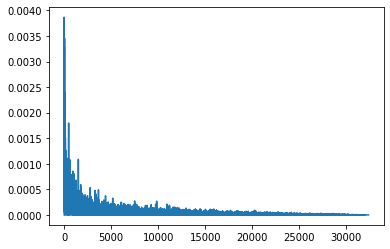

In [39]:
plt.plot(gap_vector)

In [40]:
marker = 0
for i in range(1,length-1):
    if cluster_dict_list[marker] == cluster_dict_list[i]:

        gap_vector[marker] += gap_vector[i]
        gap_vector[i] = 0
        #print(marker)


    else:
        marker = i

0.9999999999999996


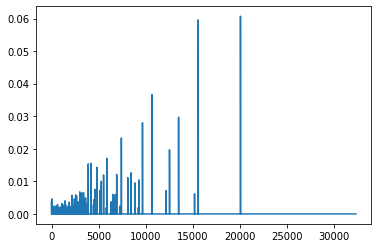

In [41]:
print(np.sum(gap_vector))
plt.plot(gap_vector)

In [42]:
candidates = np.flip(np.argsort(gap_vector))

In [43]:
counter = 0
idx = candidates[counter]
print(idx)
if idx < simplex_tree.num_vertices():
    counter += 1
    print(counter)
    idx = candidates[counter]
    print(idx)

20089


In [44]:
pred = np.array(list(cluster_dict_list[idx].values()))

In [45]:
gap_vector[candidates[0]]

0.06069843489942681

In [46]:
print(gap_vector[idx])
print('percent confidence')
'{:.1%}'.format(gap_vector[idx])

0.06069843489942681
percent confidence


'6.1%'

In [47]:
np.array(list(cluster_dict_list[idx].values()))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [48]:
#cluster_idx_array = (np.unique(np.array(list(cluster_dict_list[idx].values()))))
#print(cluster_idx_array)
#print(np.count_nonzero(cluster_idx_array))

number_of_clusters = np.count_nonzero(np.unique(np.array(list(cluster_dict_list[idx].values()))))
print(number_of_clusters)
print('your dataset appears to have', number_of_clusters,'clusters, not including any outliers')
#return counts from np.unique? to filter out small clusters?

1
your dataset appears to have 1 clusters, not including any outliers


In [49]:
true = y

print(metrics.adjusted_rand_score(true, pred))
print(metrics.silhouette_score(X, pred, metric="sqeuclidean"))

0.0
-0.08787266705614455


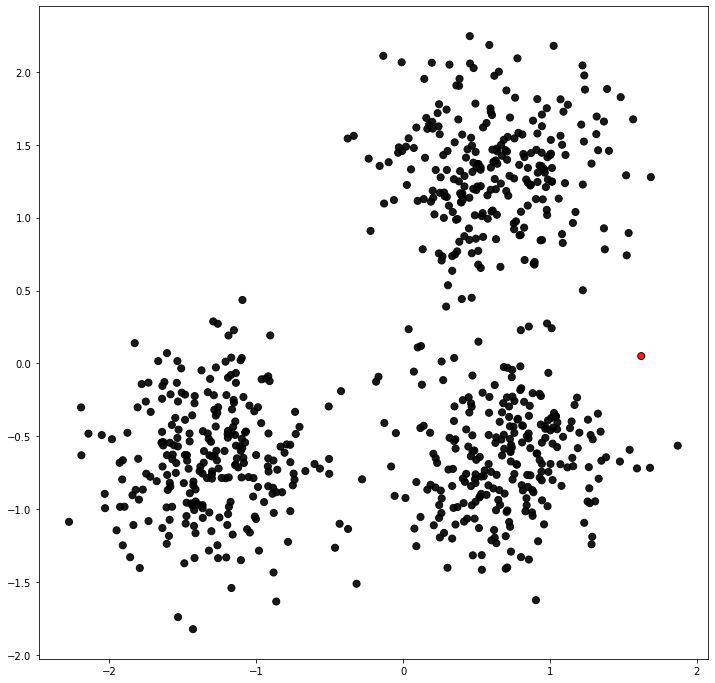

In [50]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=np.array(list(cluster_dict_list[idx].values())),
            marker="o",
            cmap='flag',
            norm=None,
            alpha=.9,
            edgecolor="k")

In [51]:
idx_list = []
for i in range(len(candidates)):
    if candidates[i] > simplex_tree.num_vertices():
        idx_list.append(candidates[i])
    else:
        break


In [52]:
idx_list = candidates[:100]
idx_list

array([20089, 15598, 10681, 13506,  9669,  7424, 12543,  5875,  4182,
        3904,  4817,  8461,  6928,  5532,  8104,  9285,  5290,  8890,
        4609,  5136, 12191,  3004,  3402,  3227, 15204,  6512,  6777,
        2569,  2172,  2659,  3319,  3616,  3171,  2429,    25,  3490,
        6663,  4514,  1419,     1,  2494,  2916,  6344,  1888,  2766,
           2,  1457,    45,    29,    18,  2731,    14,  3707,  1124,
        2852,  1078,   637,  1499,    20,  1338,  4455,  4763,    43,
           7,  3119,  1836,  1147,   281,    90,   473,  7267,  1786,
         581,  3800,  2331,  1383,  1717,  2027,   611,  1288,  7348,
        1177,  2071,   802,  1027,  2100,   130,   954,    15,   252,
          37,  9227,  3762,    65,    23,    60,  5823,  1003,  1231,
          28])

In [53]:
idx_list.sort()

In [54]:
#idx_list = [x for x in idx_list if x < idx]

In [55]:
idx_array = np.asarray(idx_list)
idx_array

array([    1,     2,     7,    14,    15,    18,    20,    23,    25,
          28,    29,    37,    43,    45,    60,    65,    90,   130,
         252,   281,   473,   581,   611,   637,   802,   954,  1003,
        1027,  1078,  1124,  1147,  1177,  1231,  1288,  1338,  1383,
        1419,  1457,  1499,  1717,  1786,  1836,  1888,  2027,  2071,
        2100,  2172,  2331,  2429,  2494,  2569,  2659,  2731,  2766,
        2852,  2916,  3004,  3119,  3171,  3227,  3319,  3402,  3490,
        3616,  3707,  3762,  3800,  3904,  4182,  4455,  4514,  4609,
        4763,  4817,  5136,  5290,  5532,  5823,  5875,  6344,  6512,
        6663,  6777,  6928,  7267,  7348,  7424,  8104,  8461,  8890,
        9227,  9285,  9669, 10681, 12191, 12543, 13506, 15204, 15598,
       20089])

In [56]:
silhouette_list = []
for i in idx_list:
    
    silhouette = metrics.silhouette_score(X, np.array(list(cluster_dict_list[i].values())), metric="euclidean")
    silhouette_list.append(silhouette)

In [57]:
silhouette_array = np.asarray(silhouette_list)

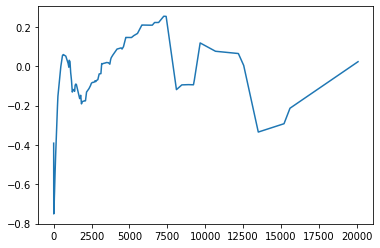

In [58]:
plt.plot(idx_array,silhouette_array)

In [59]:
idx = idx_array[silhouette_array.argmax()]
idx

7267

In [60]:
pred = np.array(list(cluster_dict_list[idx].values()))
rand_score = metrics.adjusted_rand_score( true, pred)
rand_score

0.9499573611651256

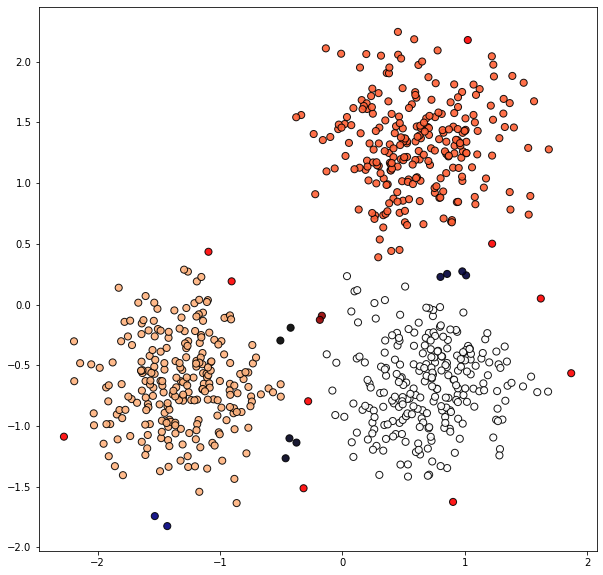

In [61]:
size=10
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=pred,
            marker="o",
            cmap=cmap,
            norm=None,
            alpha=.9,
            edgecolor="k")

plt.show()

In [62]:
new_scaler = np.arange(len(gap_vector))
scaler = MinMaxScaler()
new_scaler = scaler.fit_transform(new_scaler.reshape(-1,1))
#new_scaler = 1 - new_scaler
#new_scaler = np.square(new_scaler)
new_scaler = new_scaler.reshape(len(gap_vector))

In [63]:
inverted_normed_silhouette_array = np.multiply(silhouette_array,new_scaler[idx_array])

In [64]:
inverted_normed_silhouette_array

array([-1.20809080e-05, -2.73486390e-05, -1.62370321e-04, -3.18974388e-04,
       -3.41144134e-04, -4.06521713e-04, -4.47611699e-04, -5.12762003e-04,
       -5.52955569e-04, -6.16137831e-04, -6.36205102e-04, -7.91752116e-04,
       -9.01029672e-04, -9.31851566e-04, -1.17664356e-03, -1.24402491e-03,
       -1.53296568e-03, -1.82927289e-03, -1.58185989e-03, -1.32543457e-03,
       -2.01518709e-05,  9.74644050e-04,  1.08882789e-03,  1.17564985e-03,
        1.28048307e-03,  4.41534311e-04, -1.37098883e-04,  9.74538092e-04,
        7.94835587e-04, -1.11998230e-03, -1.72072085e-03, -2.60179415e-03,
       -4.98006020e-03, -4.69267750e-03, -4.97708370e-03, -5.44170195e-03,
       -4.23668240e-03, -4.07151808e-03, -4.26966648e-03, -8.71339607e-03,
       -8.13526167e-03, -1.08412025e-02, -1.04624046e-02, -1.10283316e-02,
       -1.12629754e-02, -1.13932186e-02, -8.78477401e-03, -8.18430482e-03,
       -7.40610688e-03, -6.61371071e-03, -6.49229635e-03, -6.69483829e-03,
       -6.22967977e-03, -

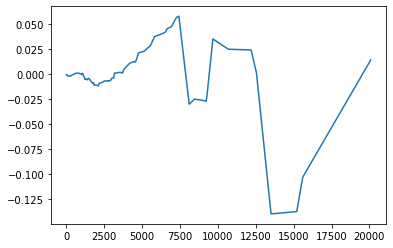

In [65]:
plt.plot(idx_array,inverted_normed_silhouette_array)

In [66]:
idx = idx_array[inverted_normed_silhouette_array.argmax()]
idx

7424

In [67]:
pred = np.array(list(cluster_dict_list[idx].values()))
rand_score = metrics.adjusted_rand_score( true, pred)
rand_score

0.9500531821373998

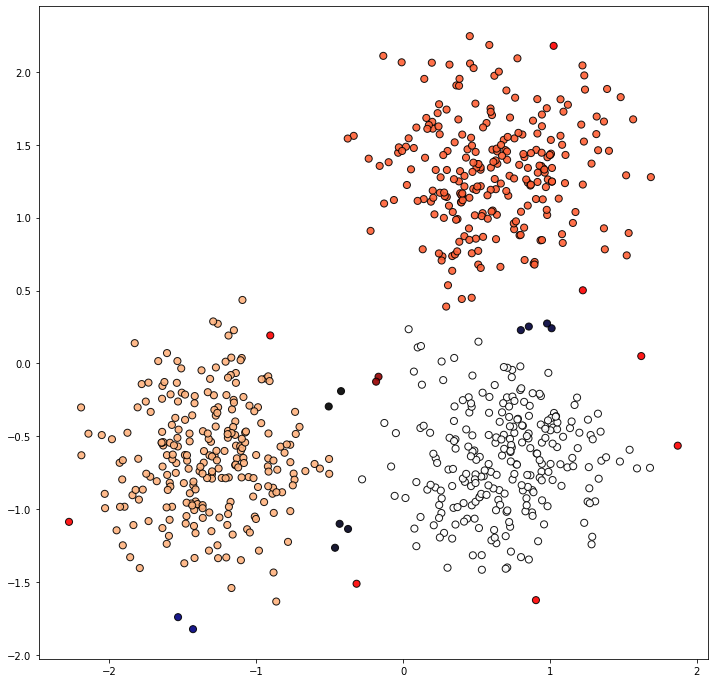

In [68]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=pred,
            marker="o",
            cmap=cmap,
            norm=None,
            alpha=.9,
            edgecolor="k")

plt.show()

In [69]:
rand_score = metrics.adjusted_rand_score( true, pred)
rand_score

0.9500531821373998

In [70]:
masked = np.ma.masked_where(metrics.rand_score(true, pred) == 1,pred)
masked

masked_array(data=[  1,   2,   1,   4,   1,   2,   2,   4,   1,   1,   2,
                     2,   2,   4,   2,   1, 227,   2, 229,   4,   4,   4,
                     4,   4,   2,   2,   4,   1,   1,   4,   1,   2,   2,
                     1,   2,   1,   4,   1,   1, 129,   4,   2,   2,   2,
                     2,   2,   1,   4,   1,   2,   4,   4,   2,   2,   4,
                     4,   2,   1,   4,   2,   4,   4,   4,   4,   4,   1,
                     4,   4,   1,   1,   1,   4,   1,   1,   4,   2,   1,
                     2,   1,   4,   2,   2,   1,   1,   1,   1,   2,   4,
                     2,   4,   4,   1,   2,   1,   2,   0,   2,   2,   1,
                     1,   4,   2,   4,   1,   4,   4,   4,   4,   1,   1,
                     1,   2,   2,   2,   2,   1,   1,   2,   1,   2,   4,
                     2,   1,   1,   2,   4,   2,   1,   1,   4,   1,   4,
                     4,   4,   1, 227,   4,   4,   1,   2,   1,   4,   1,
                     1,   4,   4, 229,

In [71]:
masked = np.ma.masked_where(pred == 0,pred)
masked

masked_array(data=[1, 2, 1, 4, 1, 2, 2, 4, 1, 1, 2, 2, 2, 4, 2, 1, 227, 2,
                   229, 4, 4, 4, 4, 4, 2, 2, 4, 1, 1, 4, 1, 2, 2, 1, 2, 1,
                   4, 1, 1, 129, 4, 2, 2, 2, 2, 2, 1, 4, 1, 2, 4, 4, 2, 2,
                   4, 4, 2, 1, 4, 2, 4, 4, 4, 4, 4, 1, 4, 4, 1, 1, 1, 4,
                   1, 1, 4, 2, 1, 2, 1, 4, 2, 2, 1, 1, 1, 1, 2, 4, 2, 4,
                   4, 1, 2, 1, 2, --, 2, 2, 1, 1, 4, 2, 4, 1, 4, 4, 4, 4,
                   1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 4, 2, 1, 1, 2, 4,
                   2, 1, 1, 4, 1, 4, 4, 4, 1, 227, 4, 4, 1, 2, 1, 4, 1, 1,
                   4, 4, 229, 4, 2, 1, 4, 2, 2, 4, 4, 4, --, 2, 1, 2, 1,
                   2, 1, 4, 4, 199, 2, 4, 4, 2, 1, 2, 4, 4, 4, 2, 2, 4, 4,
                   1, 2, 4, 1, 1, 4, 1, 1, 2, 1, 2, 1, 2, 2, 4, 4, 1, 1,
                   2, 2, 4, 2, 4, 155, 4, 4, 1, 4, 1, 4, 4, 1, 4, 4, 4, 1,
                   1, 2, 2, --, 4, 4, 4, 4, 2, 4, 4, 1, 1, 4, 1, 1, 1, 2,
                   1, 2, 2, 2, 4, 2, 

In [72]:
#cluster_idx_array = (np.unique(np.array(list(cluster_dict_list[idx].values()))))
#print(cluster_idx_array)
#print(np.count_nonzero(cluster_idx_array))

number_of_clusters = np.count_nonzero(np.unique(np.array(list(cluster_dict_list[idx].values()))))
print(number_of_clusters)
print('your dataset appears to have', number_of_clusters,'clusters, not including any outliers')
#return counts from np.unique? to filter out small clusters?

8
your dataset appears to have 8 clusters, not including any outliers


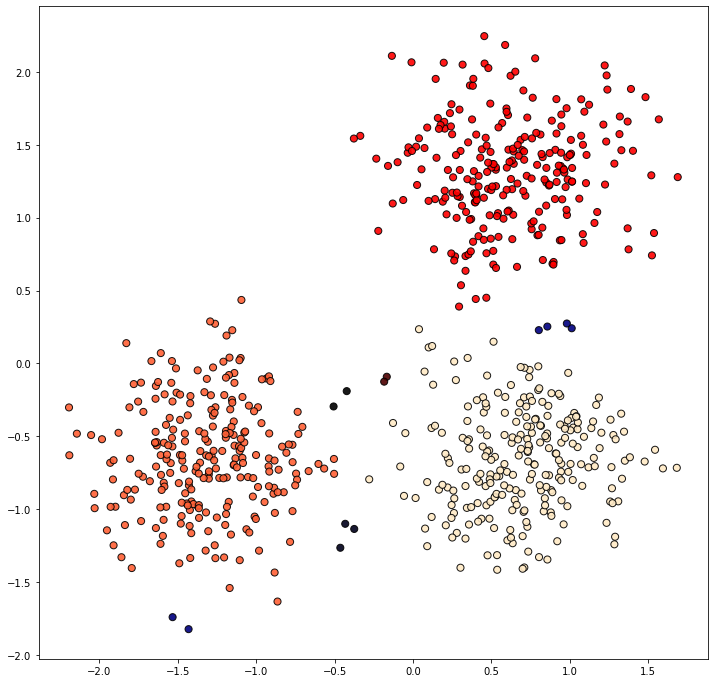

In [73]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=masked,
            marker="o",
            cmap=cmap,
            norm=None,
            alpha=.9,
            edgecolor="k")

plt.show()

In [74]:
def get_first_max(array):
    for i in range(len(array)):
        if idx_array[i] > 2*simplex_tree.num_vertices():

            if array[i] > array[i+1] and array[i+2]and array[i+3]and array[i+4]:

                return float(array[i])

In [75]:
first_max = get_first_max(silhouette_array)
idx_array[np.where(silhouette_array == first_max)]

array([1786])

In [76]:
idx = int(idx_array[np.where(silhouette_array == first_max)])
idx

1786

In [77]:
pred = np.array(list(cluster_dict_list[idx].values()))
rand_score = metrics.adjusted_rand_score( true, pred)
rand_score

0.5970742777690871

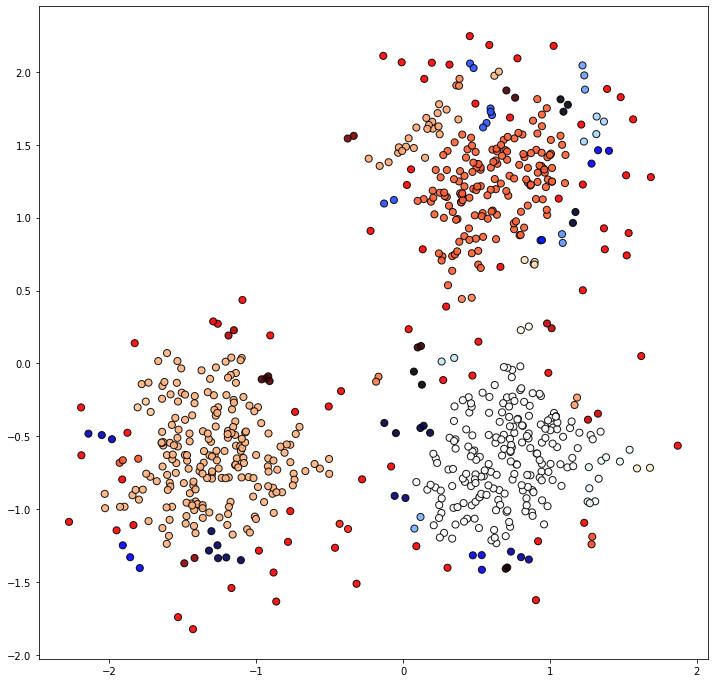

In [78]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=pred,
            marker="o",
            cmap=cmap,
            norm=None,
            alpha=.9,
            edgecolor="k")

plt.show()

In [79]:
rand_score_list = []
true = y
for i in idx_list:
    pred = np.array(list(cluster_dict_list[i].values()))
    rand_score = metrics.adjusted_rand_score( true, pred)
    rand_score_list.append(rand_score)

In [80]:
rand_score_array = np.asarray(rand_score_list)

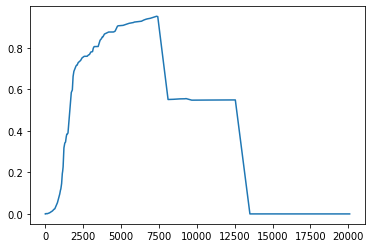

In [81]:
 plt.plot(idx_array,rand_score_array)

In [82]:
max(rand_score_array)

0.9519585377674321

In [83]:
idx = idx_array[rand_score_array.argmax()]
idx

7348

In [84]:
pred = np.array(list(cluster_dict_list[idx].values()))
rand_score = metrics.adjusted_rand_score( true, pred)
rand_score

0.9519585377674321

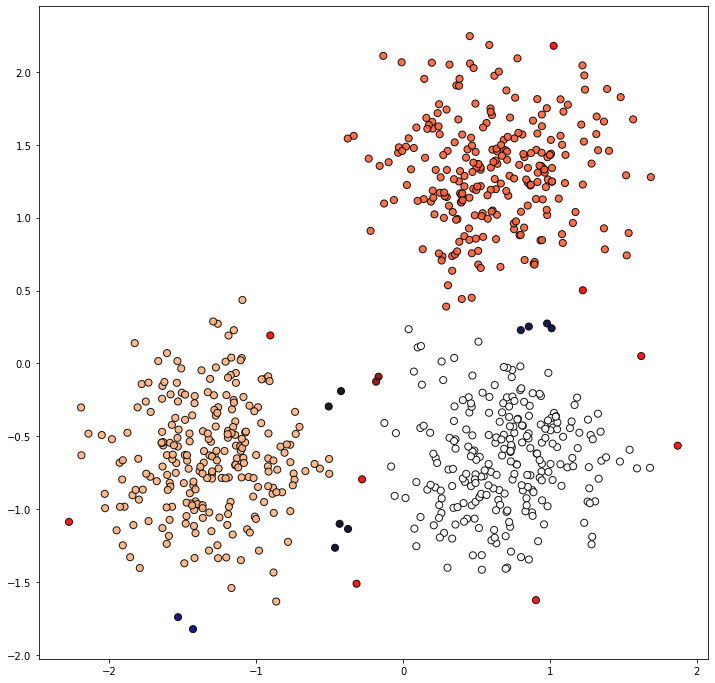

In [85]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=pred,
            marker="o",
            cmap=cmap,
            norm=None,
            alpha=.9,
            edgecolor="k")

plt.show()

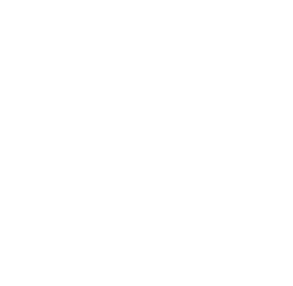

In [86]:
fig, ax = plt.subplots(figsize=(5,5))
frames = len(idx_array)
ax.set_axis_off()

outfile = filename + str(frames) + 'frames.gif'

if not os.path.isfile(outfile):
    def init():
        scatter = ax.scatter(X[:, 0], X[:, 1],
                        s=30, 
                        c=np.array(list(cluster_dict_list[0].values())),
                        marker="o",
                        cmap=cmap,
                        norm=None,
                        alpha=1,
                        edgecolor="k")
        #ax.set(xlim=(-1, 35), ylim=(-1, 35))

        return scatter,

    #collection = PatchCollection(X, animated=True)

    #ax.add_collection(collection)
    #ax.autoscale_view(True)

    def animate(i):

        scatter = ax.scatter(X[:, 0], X[:, 1],
                    s=30, 
                    c=np.array(list(cluster_dict_list[idx_array[i]].values())),
                    marker="o",
                    cmap=cmap,
                    norm=None,
                    alpha=1,
                    edgecolor="k")
        return scatter,



    ani = FuncAnimation(fig, animate,interval=180,init_func=init,frames=frames,repeat=False, blit=True)

    #ani.save('animation.gif')



    #writer=animation.PillowWriter()

    #writer = animation.FFMpegWriter(fps=2,bitrate=1000)

    ani.save(outfile,dpi=300)
    fig.show()


def pogo(dataset):
    rips_complex = gudhi.RipsComplex(points=dataset,max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])
    #move through list and assign clusters to conected components

    point_dict={i:0 for i in range(simplex_tree.num_vertices())}
    counter=0

    cluster_dict_list = []
    for i in range(simplex_tree.num_vertices(),len(df)):
        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            counter += 1
            point_dict[df.loc[i,'simplex'][0]] = counter
            point_dict[df.loc[i,'simplex'][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
            point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

            #and vice versa
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
            larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())
        #print(point_dict)
        #print('step',i)

    
    cutoff_value = 0
    for i in range(len(cluster_dict_list)):
        if cutoff_value == 0:
            if all(value != 0 for value in cluster_dict_list[i].values()):
                cutoff_value = i
                print('dataset becomes connected at simplex #',cutoff_value)
       
    df = df[:cutoff_value]
    #cluster_dict_list =
    
    #find the gaps between birth/death pairs

    df['gaps'] = df['distance'] - df['distance'].shift(1)
    
    #find normalized distance
    scaler = MinMaxScaler()
    df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

    #Mulitply the gaps by their normed location in the filtration, weighting features more heavily if they're later
    df['normed_gaps'] = df['gaps'] * df['normed_distance']

    norm_sum = df['normed_gaps'].sum()
    df['probability_vector_normed_gaps'] = df['normed_gaps'] / norm_sum
    
    gap_sum = df['gaps'].sum()
    df['probability_vector_gaps'] = df['normed_gaps'] / gap_sum

    partition = 10
    candidates = [i for i in df.nlargest(partition ,['gaps']).index if i in df.nlargest( partition,['normed_gaps']).index]
    #print('possible cuttoffs' , candidates)
    idx = cutoff_value - 1
    #idx = candidates[0]
    print('idx' ,idx)

    print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

    #print( np.array(list(cluster_dict_list[idx].values())))

    print(simplex_tree.num_vertices() , 'vertices')  
    print(simplex_tree.num_simplices(), 'simplices')
    print('dimension:', simplex_tree.dimension())

    size=10
    plt.figure(figsize=(size,size))
    plt.scatter(dataset[:, 0], dataset[:, 1],
                s=30, 
                c=np.array(list(cluster_dict_list[idx].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=.9,
                edgecolor="k")
    
    return cluster_dict_list, candidates, idx


cluster_dict_list, candidates, idx = pogo(X)

true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))
